# Imports and Data Loading

In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import keras
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D,Dense,Flatten, Dropout

from keras import optimizers
from keras import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from scipy import ndimage, misc
from keras.models import Model

C:\Users\Mateo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Imports
from keras.utils import np_utils
from numpy.random import uniform
from keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate, add
from keras.layers import Input
from keras import backend as K

## The code below requires the user to set the directory to the location of the edible plants dataset

In [3]:
# This section takes the pictures from the directory where it's located. It then goes into a double for loop looking at the files
# and the folders. The image is read as an RGB image and scaled down to a 64x64 size. It and the label, which is formatted
# through a counter, is added to a list. After the folder ends, the lists are split into training, testing, and validation.
# These splits are appended to their corresponding lists afterwards.


root = 'C:/Users/Mateo/Documents/Elec Engineering/Machine Learnin/edible wild plants dataset'
counter = -1

xtrain = []
ytrain = []
xtest = []
ytest = []
xvalid = []
yvalid = []
tempdata = []
templabel = []
for subdir, dirs, files in os.walk(root):
   
    counter = counter +1
    
    Xtrain, X_test, Ytrain, y_test = train_test_split(tempdata,templabel,test_size=.1,random_state=42)
    xtest.extend(X_test) 
    ytest.extend(y_test)
    
    X_train, X_test, y_train, y_test = train_test_split(Xtrain,Ytrain,test_size=.2,random_state=42)
    xtrain.extend(X_train)
    ytrain.extend(y_train)
    xvalid.extend(X_test) 
    yvalid.extend(y_test)
    
    tempdata = []
    templabel = []
    for file in files:
        
        filepath = os.path.join(subdir, file)
        image = ndimage.imread(filepath, mode="RGB")
        image_resized = misc.imresize(image, (64, 64))
        tempdata.append(image_resized)
        templabel.append(counter)

C:\Users\Mateo\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
C:\Users\Mateo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [4]:
# These are dimensions of the image and the number of outputs
IMAGE_HEIGHT = 64
IMAGE_WIDTH = IMAGE_HEIGHT
IMAGE_CHANNEL = 3
OUTPUTS = 62

In [5]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-Plants', verbose=1, save_best_only=True, save_weights_only=True)
]

In [6]:
def random_brightness(image):
    # Convert 2 HSV colorspace from BGR colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Generate new random brightness
    rand = np.random.uniform(0.3, 1.0)
    hsv[:, :, 2] = rand*hsv[:, :, 2]
    # Convert back to BGR colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img

# Zoom-in
def zoom(image):
    zoom_pix = np.random.randint(15, 40)
    zoom_factor = 1 + (2*zoom_pix)/IMAGE_HEIGHT
    image = cv2.resize(image, None, fx=zoom_factor,
                       fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - IMAGE_HEIGHT)//2
    left_crop = (image.shape[1] - IMAGE_WIDTH)//2
    image = image[top_crop: top_crop+IMAGE_HEIGHT,
                  left_crop: left_crop+IMAGE_WIDTH]
    return image

# Dataset Developement

In [7]:
# takes the data acquired from reading in the images and applies a zoom augmentation
length = len(xtrain)
xtrainBright = xtrain
ytrainBright = ytrain
for i in range(length):
    xy= random_brightness(xtrain[i])
    xtrainBright.append(xy)
    ytrainBright.append(ytrain[i])
    

    
    
length = len(xvalid)
xvalidBright = xvalid
yvalidBright = yvalid
for i in range(length):
    xy= random_brightness(xvalid[i])
    xvalidBright.append(xy)
    yvalidBright.append(yvalid[i])

In [8]:
# Takes the lists acquired from the previous line and applies image light augmentation to increase their sizes
length = len(xtrain)
xtrainZoom = xtrainBright
ytrainZoom = ytrainBright
for i in range(length):
    xy= zoom(xtrainBright[i])

    xtrainZoom.append(xy)
    ytrainZoom.append(ytrainBright[i])
    

    
    
length = len(xvalidBright)
xvalidZoom = xvalidBright
yvalidZoom = yvalidBright
for i in range(length):
    xy= zoom(xvalidBright[i])
    xvalidZoom.append(xy)
    yvalidZoom.append(yvalidBright[i])

In [9]:
# This changes the lists that were formed prior and changes them to arrays
Xtrain = np.array(xtrainZoom)
Ytrain = np.array(ytrainZoom)
Xtest = np.array(xtest)
Ytest = np.array(ytest)
Xvalid = np.array(xvalidZoom)
Yvalid = np.array(yvalidZoom)

In [10]:
# This prints the sizes of the arrays, change the labels to a vector with width 1
print(Xtrain.shape)
print(Ytrain.shape)
print(Ytest.shape)
print(Yvalid.shape)

Ytrain =np.reshape(Ytrain, (len(Ytrain),1))
Yvalid =np.reshape(Yvalid, (len(Yvalid),1))
Ytest =np.reshape(Ytest, (len(Ytest),1))
print(Ytrain.shape)
print(Ytest.shape)
print(Yvalid.shape)

(15692, 64, 64, 3)
(15692,)
(547,)
(3936,)
(15692, 1)
(547, 1)
(3936, 1)


In [11]:
# This one-hot encodes the labels to achieve equal weight changes
train = np_utils.to_categorical(Ytrain, num_classes=62)
Yvalid = np_utils.to_categorical(Yvalid, num_classes=62)
Ytest = np_utils.to_categorical(Ytest, num_classes=62)

In [12]:
# This normalizes the data to between 0 and 1 for the images
Xtrain = Xtrain/255
Xvalid = Xvalid/255
Xtest = Xtest/255

# Testing

In [13]:
# This function takes the history variable that is ouputted from model.fit and plots the validation and training accuracy
# and loss
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
   
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()




In [23]:
# model used for traiing the data. Split up into three sections: the first two are collections of primarily normalizations and
# convolutions with pooling and dropout afterwards; the last layer flattens it, sends it through a dense layer, applies
# dropout and then sends it to the output layer

model = Sequential()


model.add(Conv2D(32,(3,3), activation='relu', input_shape= Xtrain.shape[1:], padding = 'valid', strides=(1, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.4))
model.add(Dense(OUTPUTS))
model.add(Activation('softmax'))

In [18]:
# this compliles the model so that it can run

model.compile(optimizer = optimizers.Adam(lr=0.001, decay = .000475), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# This fits the training data to the model and gives a history object
history = model.fit(Xtrain, Ytrain,batch_size=32, validation_data=(Xvalid, Yvalid), epochs=15,callbacks=callbacks )

Train on 15692 samples, validate on 3936 samples
Epoch 1/7
15692/15692 [==============================] - 389s 25ms/step - loss: 1.3086 - acc: 0.6234 - val_loss: 2.1445 - val_acc: 0.4677

Epoch 00001: val_loss did not improve from 2.11242
Epoch 2/7
15692/15692 [==============================] - 403s 26ms/step - loss: 1.1727 - acc: 0.6608 - val_loss: 2.2374 - val_acc: 0.4672

Epoch 00002: val_loss did not improve from 2.11242
Epoch 3/7
  352/15692 [..............................] - ETA: 6:24 - loss: 0.9996 - acc: 0.6705

KeyboardInterrupt: 

In [36]:
# This loads the best weights achieved in the model above
model.load_weights('model-Plants')

In [37]:
# This prints out the accuracy of the model

test_loss, test_acc = model.evaluate(Xtest, Ytest, batch_size=32)

print('Test accuracy:', test_acc)

547/547 [==============================] - 3s 6ms/step
Test accuracy: 0.46983546623364225


In [38]:
# This uses the earlier function to plot accuracy and loss
plot_history(history)

NameError: name 'history' is not defined

In [59]:
# Used to plot the predicted values from the model

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format([predicted_label],
                                100*np.max(predictions_array),
                                [true_label]),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(62), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [60]:
predictions = model.predict(Xtest)

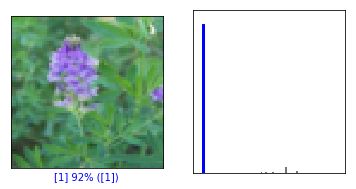

In [69]:
i = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, ytest, Xtest)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  ytest)